In [1]:
import torch
from torch import nn, optim
import torchvision as vis
from torch.utils import data
import numpy as np
from tqdm import tqdm
import math

import os, sys

has_cuda = torch.cuda.is_available()
# has_cuda = False
is_windows = sys.platform == "win32"

if has_cuda:
  print(torch.cuda.get_device_name(0))
else:
  print("CPU")
device = torch.device("cuda:0" if has_cuda else "cpu")

Tesla T4


In [2]:
from model_helper import ModelSaver, load_model, model_store, StoredModel
from dataset.video_dataset import VideoFramesDatasetWithSplit

In [3]:
preprocess = vis.transforms.Compose([
  vis.transforms.Resize(64),
  vis.transforms.ToTensor()])

In [4]:
train_dataset = VideoFramesDatasetWithSplit(
  "subset_splits/train_set.csv",
  "/home/ubuntu/data/resized_frames",
  "/home/ubuntu/data/transcriptions",
  preprocess)

validation_dataset = VideoFramesDatasetWithSplit(
  "subset_splits/val_set.csv",
  "/home/ubuntu/data/resized_frames",
  "/home/ubuntu/data/transcriptions",
  preprocess)

test_dataset = VideoFramesDatasetWithSplit(
  "subset_splits/test_set.csv",
  "/home/ubuntu/data/resized_frames",
  "/home/ubuntu/data/transcriptions",
  preprocess)

In [5]:
from model.vae_3d import VAE3D
from model.video_encoder_with_text import VideoEncoderWithLM, VideoEncoderWithLMExpert, VideoEncoderWithLMExpertShared

In [ ]:
from torchinfo import summary
model_id = "video_encoder_with_text_128_shared_64_01"

def init_weights(model):
    torch.nn.init.kaiming_uniform_(model.weight)
    model.bias.data.fill_(0.0)

_, lang_model, _, _, _ = load_model("lang_model_02", device)
# model = VideoEncoderWithLMExpert(VAE3D(128, loss_type="H"),
#                           lang_model,
#                           nn.Sequential(nn.Linear(400, 1024), nn.BatchNorm1d(1024), nn.GELU(),
#                                         nn.Linear(1024, 128))
#                           )
# model = VideoEncoderWithLMExpert(VAE3D(128, loss_type="H"),
#                           lang_model,
#                           nn.Sequential(nn.Linear(400, 1024), nn.BatchNorm1d(1024), nn.GELU(),
#                                         nn.Linear(1024, 128))
#                           )
model = VideoEncoderWithLMExpertShared(VAE3D(128, loss_type="H"),
                          lang_model,
                          nn.Sequential(nn.Linear(400, 1024), nn.BatchNorm1d(1024), nn.GELU(),
                                        nn.Linear(1024, 128)),
                          n_shared=64
                          )

print(model)

epoch_start = 1
# model.apply(init_weights)
model.to(device)
# model_spec = str(summary(model, ((2, 1, 5, 64, 64), (2, 3, 64, 64))))
# print(model_spec)

In [8]:
try:
  os.mkdir(f"{model_store}/{model_id}")
except:
  print("WARNING: directory exists")
# save model summary to a txt file
with open(f"{model_store}/{model_id}/model_spec.txt", "w") as file:
  file.write(str(model) + "\n")
  # file.write(model_spec.replace("├─", "|-"))

In [6]:
model_id = "video_encoder_with_text_prod_of_expert_02"
epoch_start, model, optimizer, scheduler, criterion = load_model(model_id, device)

resuming from last checkpoint epoch_60


In [12]:
scheduler.step_size = 10

In [8]:
model_id = "uni_3d_vae_full_data_low_lr"

In [13]:
optimizer.param_groups[0]["lr"] = 5e-4
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

In [9]:
os.mkdir(f"{model_store}/{model_id}")
# save model summary to a txt file
with open(f"{model_store}/{model_id}/model_spec.txt", "w") as file:
  file.write(str(model) + "\n")

In [8]:
train_dataloader_args = dict(batch_size=160,
                             num_workers=torch.get_num_threads() * 2 if not is_windows else 0) if has_cuda else dict(batch_size=64)
train_dataloader_args["shuffle"] = True
train_dataloader_args["collate_fn"] = VideoFramesDatasetWithSplit.collate_fn

validation_dataloader_args = train_dataloader_args.copy()
validation_dataloader_args["shuffle"] = False

train_dataloader = data.DataLoader(train_dataset, **train_dataloader_args)
validation_dataloader = data.DataLoader(validation_dataset, **validation_dataloader_args)

In [8]:
def run_model(model, dataloader, epoch):
  cumulative_stats = {}
  
  num_batches = 0
  
  prog_bar = tqdm(dataloader, desc="Train" if model.training else "Eval ")
  
  if epoch >= 20:
    train_lm = True
  else:
    train_lm = False

  for video, _, (text, text_len) in prog_bar:
    video = video[:, :, :-1].to(device)
    text = text.to(device)
    
    num_batches += 1
    batch_size = video.shape[0]
    
    if model.training:
      optimizer.zero_grad() # clear calculated gradients
      
    with torch.cuda.amp.autocast():
      # video_embedding, text_embedding = model(video, text, text_len, train_lm)
      # losses = model.loss(video, video_embedding, text_embedding)
      video_embedding = model(video, text[:, 1:], text_len - 2, train_lm)
      losses = model.loss(video, video_embedding)
    
    loss = losses["loss"]
    
    if math.isnan(loss):
      continue
    
    if model.training:        
      # backprop loss
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      
    # accumulate and display stats
    for k, v in losses.items():
      if type(v) is torch.Tensor:
        v = v.item()
      if k in cumulative_stats:
        cumulative_stats[k] += v
      else:
        cumulative_stats[k] = v
    
    prog_bar.set_postfix(**{k[:5]: v / num_batches for k, v in cumulative_stats.items()},
                         lr=f'{optimizer.param_groups[0]["lr"]:.6f}')
  
  # average stats across batches
  for k, v in cumulative_stats.items():
      cumulative_stats[k] = v / len(dataloader)
  
  return cumulative_stats

In [9]:
from itertools import chain

num_epochs = 60

if epoch_start == 1:
  # define only at the start of the training
  print("New Model")
  
  regularization = 1e-5
  learning_rate = 1e-3
  optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=regularization)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.5)
else:
  print("Existing Model")

scaler = torch.cuda.amp.GradScaler() # mix-precision training
model_saver = ModelSaver(model_id, mode="min", regular_save_interval=5)

with open(f"{model_store}/{model_id}/training_params.txt", "w") as file:
  file.write(f"num_epochs = {num_epochs}\n")
  # file.write(f"criterion = {criterion}\n")
  file.write(f"optimizer = {optimizer}\n")
  file.write(f"scheduler = {type(scheduler).__name__}({scheduler.state_dict()})\n")

Existing Model


In [ ]:
from tqdm import tqdm
import sys
import json

print(f"Model: {model_id}. Training for {num_epochs} epochs", file=sys.stderr)

for epoch in range(epoch_start, num_epochs + 1):
  print(f"Epoch {epoch}", file=sys.stderr)
  
  # set model in training mode
  model.train()
  train_stats = run_model(model, train_dataloader, epoch)
  
  # set model to eval mode
  model.eval()
  with torch.no_grad():
    eval_stats = run_model(model, validation_dataloader, epoch)
    
  # let scheduler know it's the next epoch
#   scheduler.step(eval_stats["accuracy"])
  
  stats = {
    "epoch": epoch,
    "train_stats": train_stats,
    "eval_stats": eval_stats,
    "learning rate": optimizer.param_groups[0]["lr"]
  }
  
  scheduler.step()
  
  if math.isnan(train_stats["loss"]):
    print("NaN loss detected! Stop Training")
    break
    
  model_saver.save(StoredModel(model, optimizer, scheduler, None), stats, eval_stats["loss"])

In [6]:
model_id = "video_encoder_with_text_01"
_, model, _, _, _ = load_model(model_id, device, 59)

resuming from last checkpoint epoch_59


In [37]:
import matplotlib.pyplot as plt

def show_video(video):
  grayscale = video.shape[0] == 1
  fig, axs = plt.subplots(1, video.shape[1], figsize=(15,3))
  
  for idx in range(video.shape[1]):
    frame = video[:, idx]
    if grayscale:
      frame = frame.squeeze()
    else:
      frame = frame.permute(1,2,0)
    axs[idx].imshow(frame, cmap="gray" if grayscale else None)
    axs[idx].axis('off')
  
  plt.show()

In [56]:
%config InlineBackend.figure_format = 'retina'

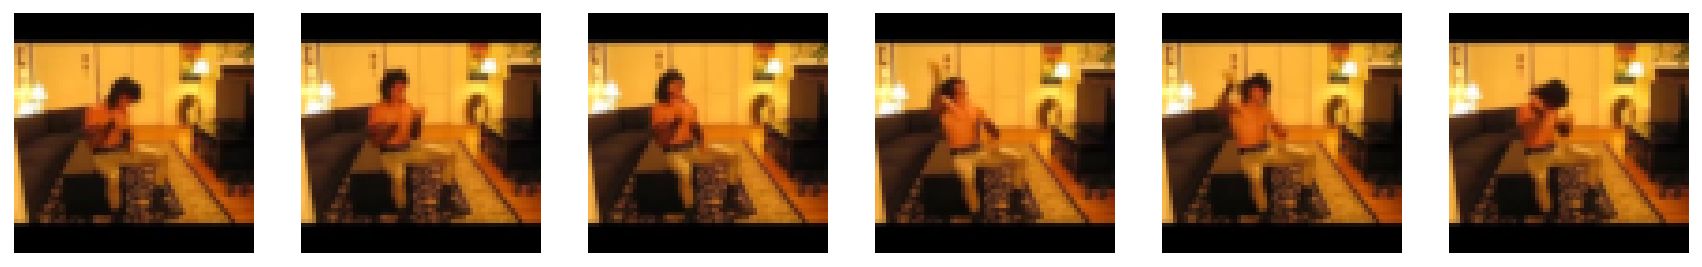

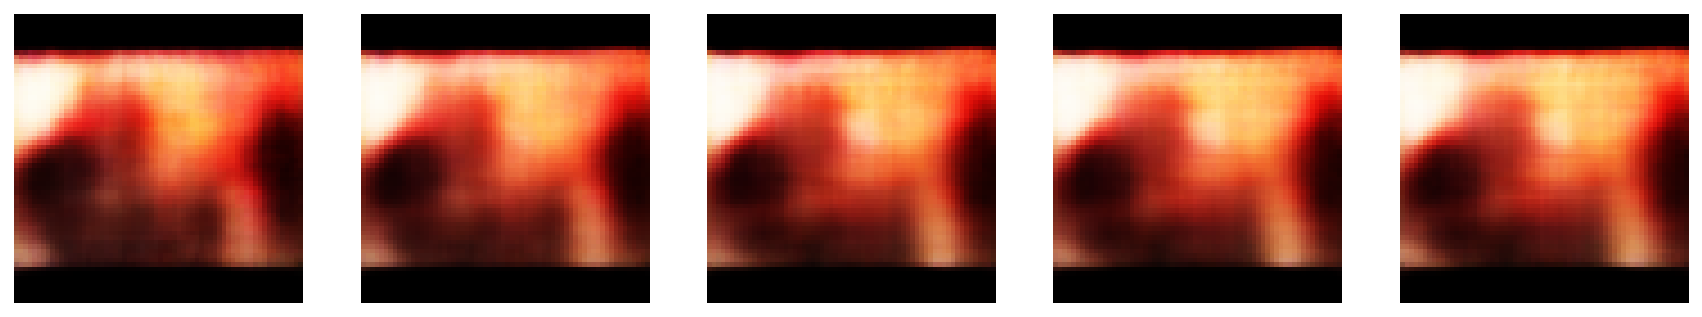

In [26]:
from dataset.triplet_dataset import tokenize
dataset = validation_dataset

video_id = 282

video = dataset[video_id][0]

text, text_len = tokenize(dataset[video_id][2])

show_video(video)

model.eval()

with torch.no_grad():
  video_embedding = model(video.unsqueeze(0).to(device), text[:, 1:].to(device), text_len - 2, False)
  res = model.video_encoder.decode(video_embedding)
  
show_video(res[0].cpu().sigmoid())

In [10]:
def get_embeddings(dataset):
  video_embeddings = list()
  # text_embeddings = list()
  model.eval()
  test_dataloader = data.DataLoader(dataset, **validation_dataloader_args)

  with torch.no_grad():
    for video, _, (text, text_len) in tqdm(test_dataloader, ncols=100, desc="Eval"):
      video = video.to(device)
      video_embedding, _ = model(video.to(device), text[:, 1:].to(device), text_len - 2, False)

      video_embeddings.append(video_embedding)

  video_embeddings = torch.cat(video_embeddings).cpu()
  # text_embeddings = torch.cat(text_embeddings).cpu()
  return video_embeddings

In [11]:
train_video_embeddings = get_embeddings(train_dataset)

Eval: 100%|███████████████████████████████████████████████████████| 383/383 [03:49<00:00,  1.67it/s]


In [12]:
from tsne.data_interface import *

In [13]:
filename = pack_bin_file(train_video_embeddings.numpy(), "tsne/" + model_id)

In [29]:
filename = pack_bin_file(train_video_embeddings.cpu().numpy()[:, 64:], "tsne/" + "128_private_64")

In [14]:
!tsne/bhtsne -f $filename -n 4 -od "tsne/output" -i 900

Read 61136 x 128 data matrix successfully!
Using no_dims = 2, perplexity = 50.000000, and theta = 0.500000
Computing input similarities...
Building tree takes 0.1519
Computing perplexity with nearest neighbors...
 - point 12227 of 61136
 - point 24454 of 61136
 - point 36681 of 61136
 - point 48908 of 61136
 - point 61135 of 61136
Computing asymmetric pairwise similarities takes 56.2491
Symmetrization takes 3.8824
Perplexity computed in 60.1511 seconds (sparsity = 0.004608)!
Learning embedding...
Iteration 101: error is 115.292770 (100 iterations in 2.0248 seconds)
Iteration 201: error is 112.464653 (100 iterations in 2.0320 seconds)
Iteration 301: error is 5.631711 (100 iterations in 2.0938 seconds)
Iteration 401: error is 5.195600 (100 iterations in 1.8571 seconds)
Iteration 501: error is 5.028889 (100 iterations in 1.8514 seconds)
Iteration 601: error is 4.925414 (100 iterations in 1.8664 seconds)
Iteration 701: error is 4.855830 (100 iterations in 1.8613 seconds)
Iteration 801: err

In [15]:
tsne_embed = load_bin_file("tsne/output/tsne_2d_" + filename[5:-4] + "_4.bin")

In [16]:
label_to_idx = dict()
colors = list()
for v in train_dataset.videos:
  category = v[0]
  if category in label_to_idx:
    idx = label_to_idx[category]
  else:
    idx = len(label_to_idx)
    label_to_idx[category] = idx
  colors.append(idx) 

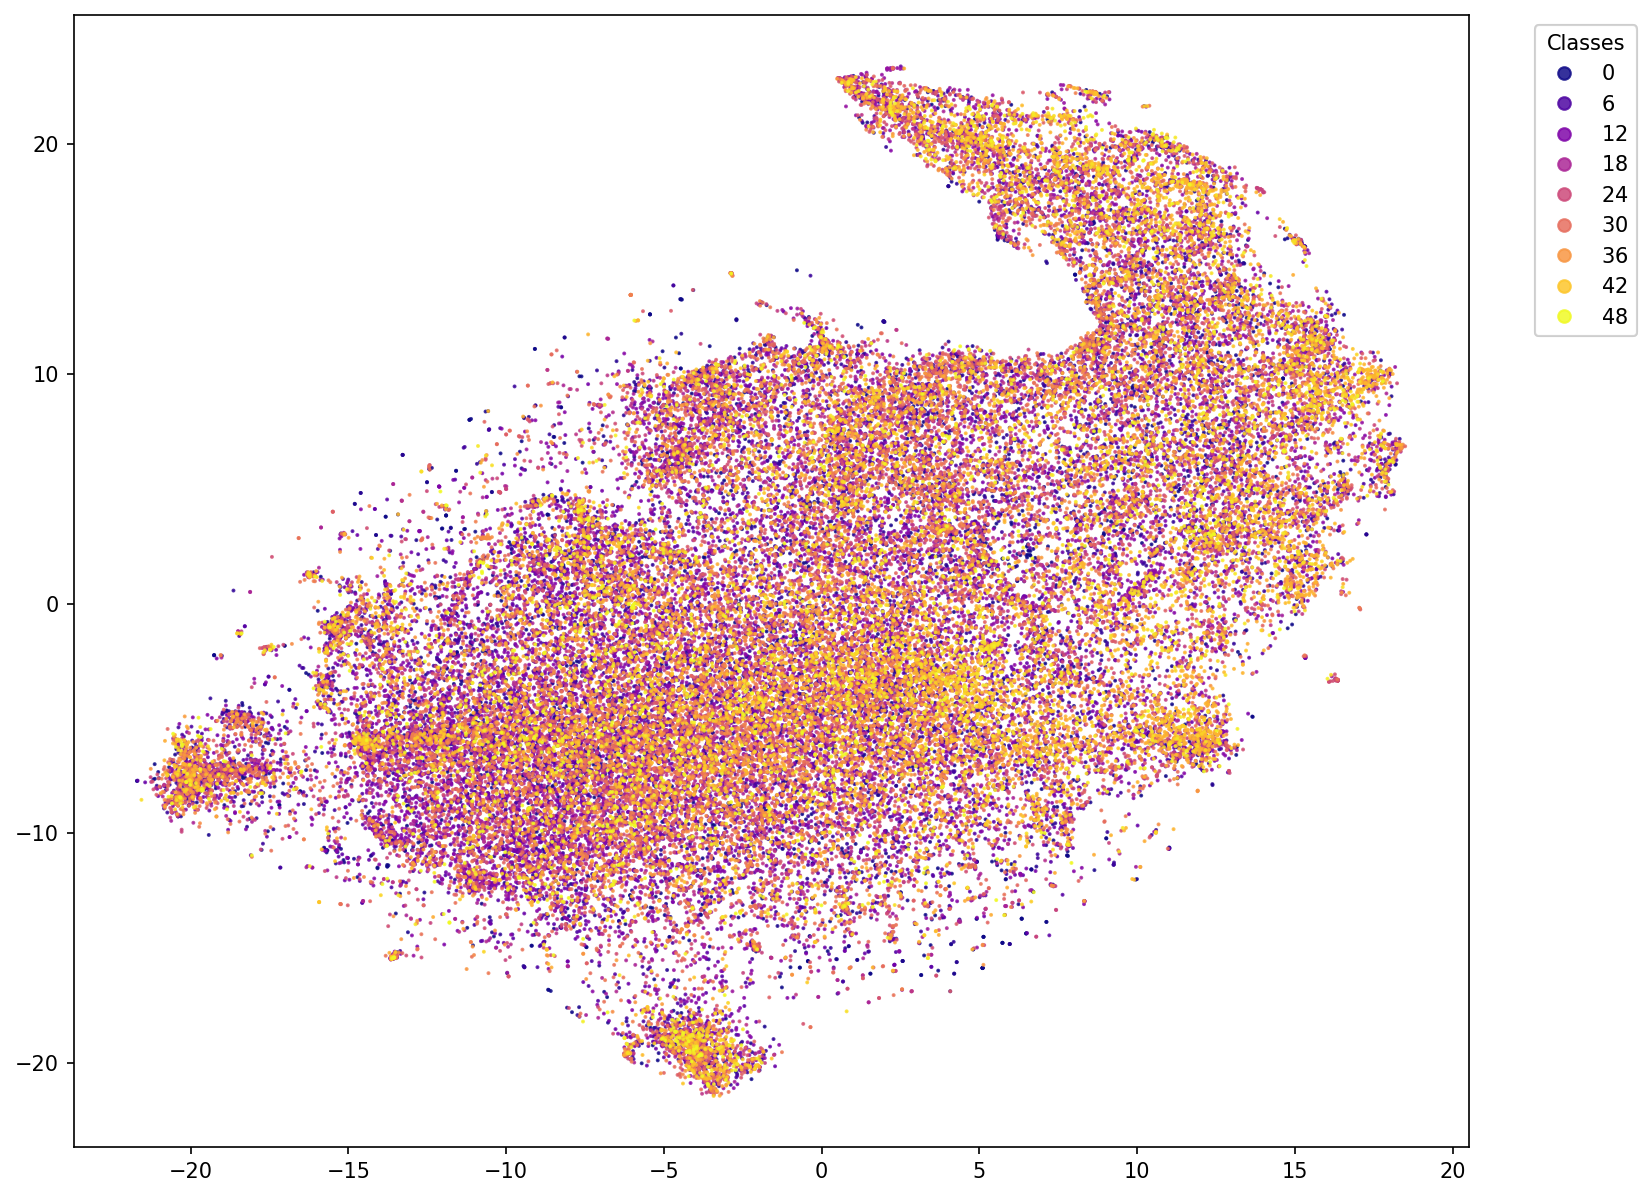

In [ ]:
visualize_tsne_result(tsne_embed, labels=colors, dot_size=0.8, filename="video_with_text_embedding_L1_tsne.jpg")

In [ ]:
# train clip text embedding
visualize_tsne_result(tsne_embed, labels=colors, dot_size=0.8)

In [33]:
# test KNN

from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5, n_jobs=-1)
knn.fit(train_video_embeddings)

NearestNeighbors(n_jobs=-1)

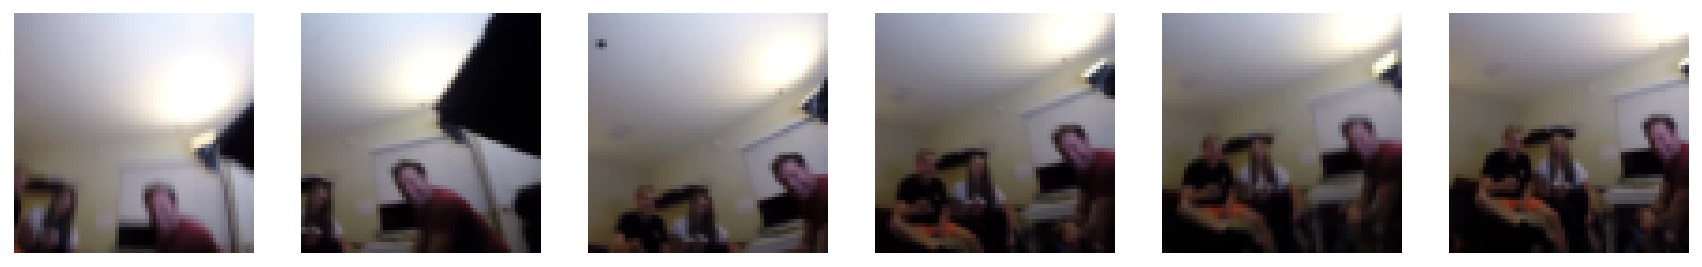

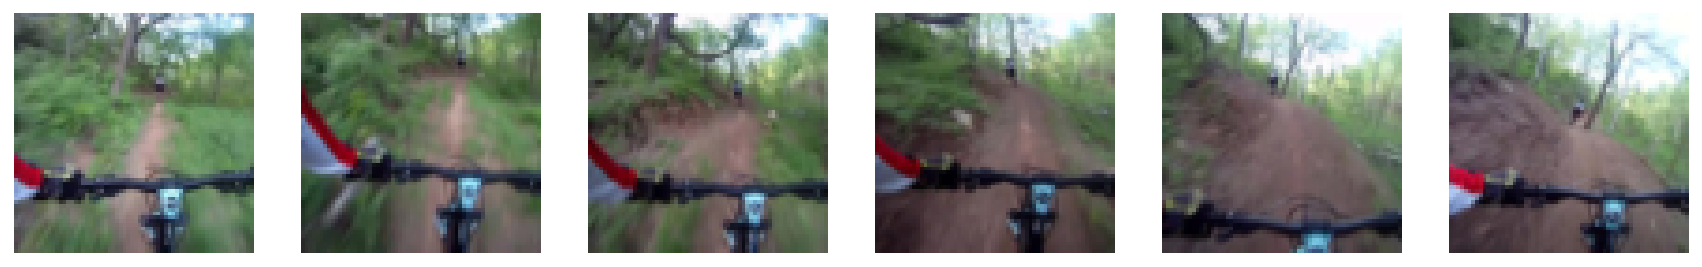

In [40]:
_, neighbors = knn.kneighbors(video_embeddings[2900].unsqueeze(0))
for video_id in neighbors[0]:
  video = train_dataset[video_id][0]
  show_video(video)

In [34]:
eval_embeddings = torch.cat([get_embeddings(validation_dataset), get_embeddings(test_dataset)])

Eval: 100%|███████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


In [35]:
_, neighbors = knn.kneighbors(eval_embeddings)

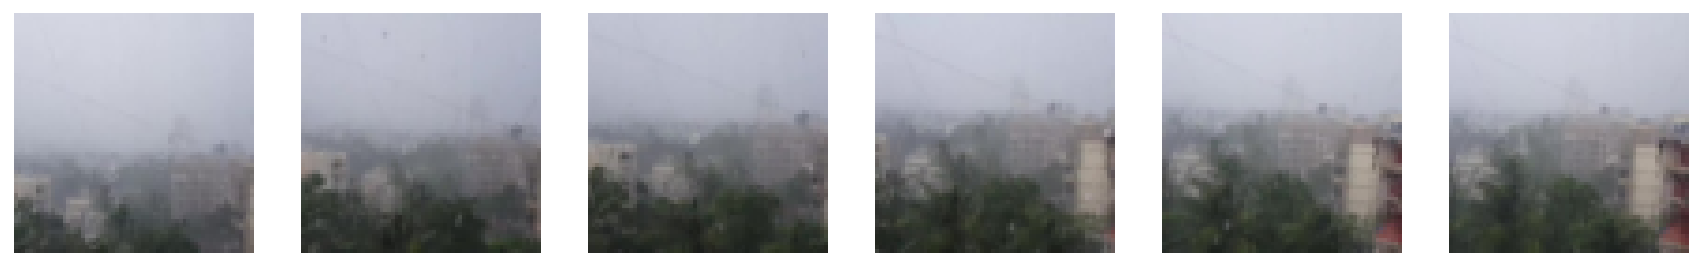

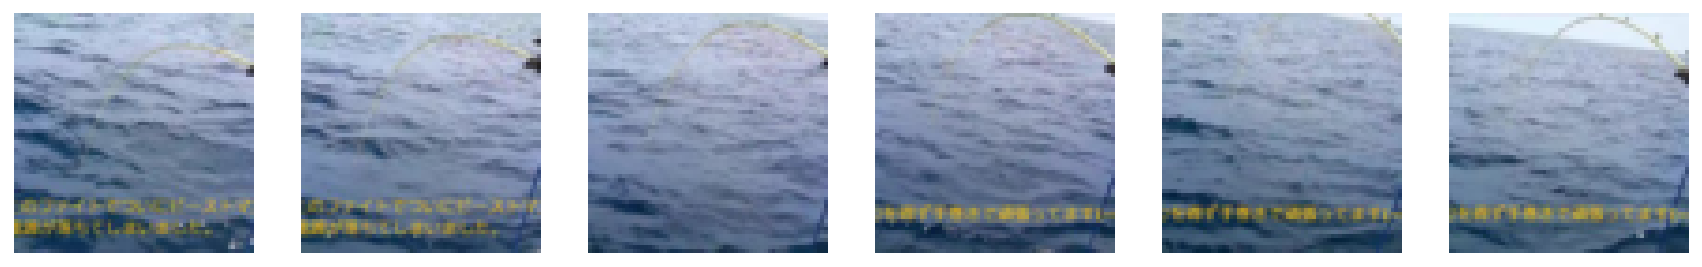

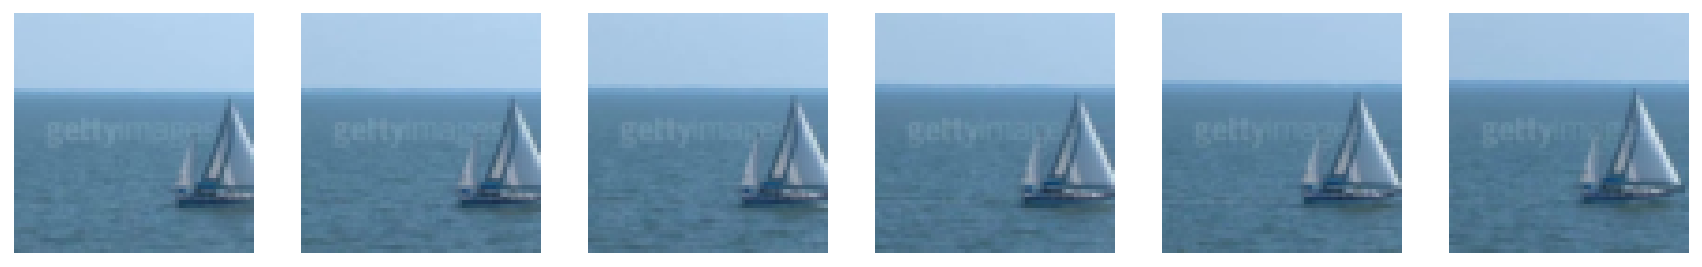

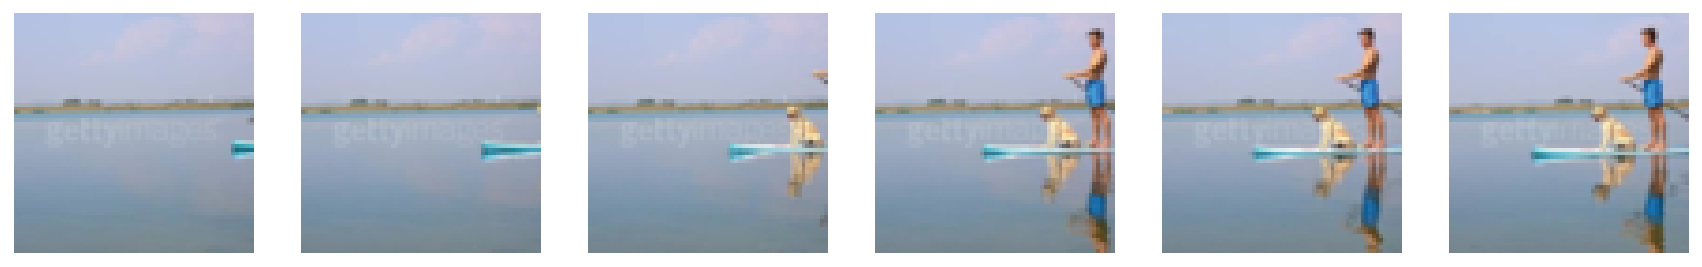

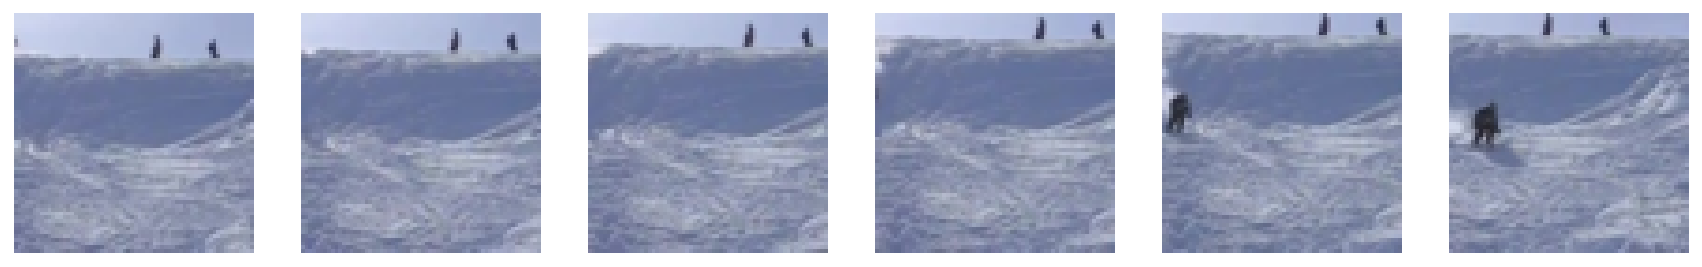

In [65]:
eval_id = 995
show_video(validation_dataset[eval_id][0])
for video_id in neighbors[eval_id]:
  video = train_dataset[video_id][0]
  show_video(video)

In [13]:
metric = nn.CosineSimilarity()
def compute_clip_similarity(train_clips, eval_clips, neighbors):
  total_similarity = 0
  for neighbor_list, self_clip in zip(neighbors, eval_clips):
    neighbor_clips = train_clips[neighbor_list]
    total_similarity += metric(self_clip.expand(neighbor_clips.size(0), -1), neighbor_clips)
  return total_similarity / eval_clips.size(0)

In [2]:
train_clip_embed = torch.load("clip_embeddings/train_text.pth")
val_clip_embed = torch.load("clip_embeddings/val_text.pth")
test_clip_embed = torch.load("clip_embeddings/test_text.pth")

In [6]:
val_clip_embed.shape

torch.Size([1061, 512])

In [5]:
test_clip_embed.shape

torch.Size([302, 512])

In [30]:
# embedding L1 loss
compute_clip_similarity(train_clip_embed, torch.cat([val_clip_embed, test_clip_embed]),
                       neighbors)

tensor([0.5938, 0.5840, 0.5791, 0.5815, 0.5791], device='cuda:0',
       dtype=torch.float16)

In [37]:
# product of expert
compute_clip_similarity(train_clip_embed, torch.cat([val_clip_embed, test_clip_embed]),
                       neighbors)

tensor([0.5977, 0.5830, 0.5845, 0.5815, 0.5806], device='cuda:0',
       dtype=torch.float16)

In [62]:
# CLIP video embedding
compute_clip_similarity(train_clip_embed, torch.cat([val_clip_embed, test_clip_embed]),
                       neighbors)

tensor([0.7051, 0.6938, 0.6836, 0.6875, 0.6821], device='cuda:0',
       dtype=torch.float16)

In [15]:
# 128 share 64
compute_clip_similarity(train_clip_embed, torch.cat([val_clip_embed, test_clip_embed]),
                       neighbors)

tensor([0.6001, 0.5840, 0.5864, 0.5850, 0.5869], device='cuda:0',
       dtype=torch.float16)

In [9]:
sum([0.6001, 0.5840, 0.5864, 0.5850, 0.5869]) / 5

0.58848

In [47]:
import clip
# pip install git+https://github.com/openai/CLIP.git
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [58]:
def get_embeddings(dataset):
  video_embeddings = list()
  # text_embeddings = list()
  model.eval()
  test_dataloader = data.DataLoader(dataset, **validation_dataloader_args)

  with torch.no_grad():
    for video, _, (text, text_len) in tqdm(test_dataloader, ncols=100, desc="Eval"):
      batch_size = video.size(0)
      video = video.to(device).transpose(1, 2)
      video_embedding = clip_model.encode_image(video.reshape(-1, *video.shape[2:])).reshape(batch_size, 6, -1).mean(1)

      video_embeddings.append(video_embedding)

  video_embeddings = torch.cat(video_embeddings).cpu()
  # text_embeddings = torch.cat(text_embeddings).cpu()
  return video_embeddings